In [10]:
%matplotlib inline

from bleu import compute_bleu
from data_loader import tokenize_de, tokenize_en
from device import select_device, with_cpu, with_gpu
from main import evaluate_batch
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from parse import get_config
from random import sample
import torch
import torchtext
from utils import filter_words, get_text, list2words, torch2words

# Model

Load weights of model and parses model configuration.

In [13]:
name = 'final'
config_path = f'configs/{name}.json'

In [3]:
use_gpu, device, device_idx = select_device()
config = get_config(use_gpu, device, device_idx, load_weights=True, config_path=config_path, parse_args=False)
source_language = config.get('src_language')
target_language = config.get('trg_language')

# Load Test Data

In [4]:
csv_dir_path = '.data/multi30k'
EOS_token = config.get('EOS_token')
PAD_token = config.get('PAD_token')
SOS_token = config.get('SOS_token')
source_field = torchtext.data.Field(
    tokenize=tokenize_de,
    init_token=SOS_token,
    eos_token=EOS_token,
    pad_token=PAD_token,
    include_lengths=True
)
target_field = torchtext.data.Field(
    tokenize=tokenize_en,
    init_token=SOS_token,
    eos_token=EOS_token,
    pad_token=PAD_token,
    include_lengths=True
)
data_fields = [('src', source_field), ('trg', target_field)]
train, val, test = torchtext.data.TabularDataset.splits(
    path=csv_dir_path,
    test='test.csv',
    train='train.csv',
    validation='val.csv',
    format='csv',
    fields=data_fields,
    skip_header=True
)
source_vocabulary_size = config.get('source_vocabulary_size')
target_vocabulary_size = config.get('target_vocabulary_size')
source_field.build_vocab(train, val, max_size=source_vocabulary_size)
target_field.build_vocab(train, val, max_size=target_vocabulary_size)
_, _, test_iter = torchtext.data.BucketIterator.splits(
    (train, val, test),
    batch_size=config.get('batch_size'),
    device=device,
    shuffle=True,
    sort_key=lambda x: len(x.src)
)

# BLEU

In [5]:
reference_corpus = []
translation_corpus = []
for test_batch in test_iter:
    test_loss, translations = evaluate_batch(config, test_batch)
    test_batch_trg, _ = test_batch.trg
    _, batch_size = test_batch_trg.shape
    references = map(lambda i: torch2words(target_language, test_batch_trg[:, i]), range(batch_size))
    references = map(lambda words: [list(filter_words(words, SOS_token, EOS_token, PAD_token))], references)
    reference_corpus.extend(references)
    translations = map(lambda translation: list2words(target_language, translation), translations)
    translations = map(lambda words: list(filter_words(words, SOS_token, EOS_token, PAD_token)), translations)
    translation_corpus.extend(translations)
bleu = compute_bleu(reference_corpus, translation_corpus)
print(f'BLEU on test set: {bleu}')

BLEU on test set: 13.45309095227909


# Sample Translations

In [6]:
k = 2
test_data = test_iter.data()
test_dataset = test
test_batch = torchtext.data.Batch(sample(test_data, k), test_dataset, device)
test_batch_src, _ = test_batch.src
test_batch_trg, _ = test_batch.trg
_, translations, _ = evaluate_batch(config, test_batch, True)
for i in range(k):
    source_words = torch2words(source_language, test_batch_src[:, i])
    target_words = torch2words(target_language, test_batch_trg[:, i])
    translation_words = list(filter(lambda word: word != PAD_token, list2words(target_language, translations[i])))
    text = get_text(source_words, target_words, translation_words, SOS_token, EOS_token, PAD_token)
    print(text)


    Source: "Diese Band bereitet sich auf einen Auftritt vor Publikum in einer Kirche vor ."
    Target: "This band is getting ready to perform in front of an audience at church ."
    Translation: "These band are the a a of front front front of a . ."
    

    Source: "Ein Mann in einem gelben Mantel <unk> auf ein Feuer , ein Junge im Anorak sieht zu ."
    Target: "A man in a yellow coat tends a fire , a boy in a parka watches ."
    Translation: "A man in a yellow coat is a a a a a a a a a . ."
    


# Attention

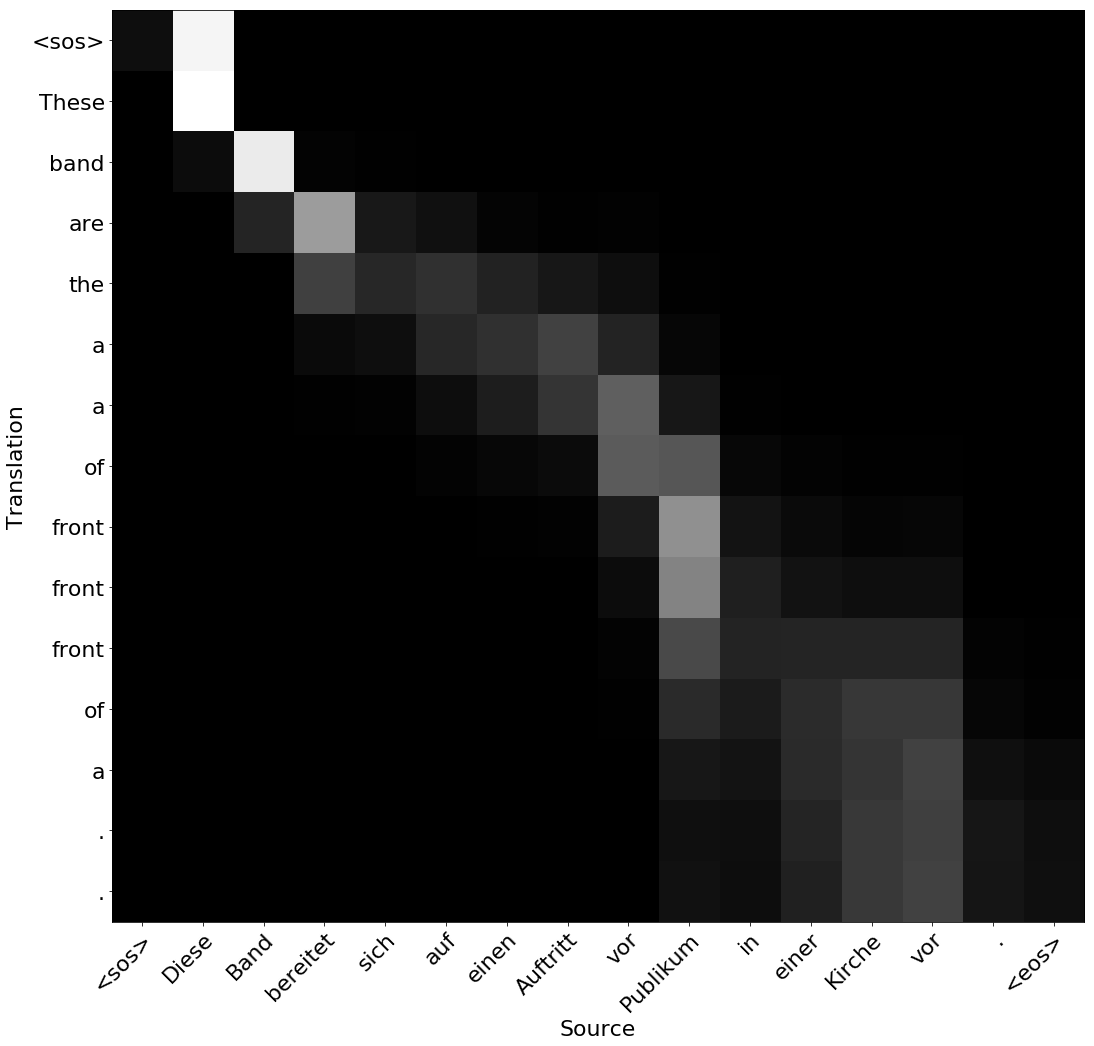

In [8]:
_, translations, attention_weights = evaluate_batch(config, test_batch, True)
source_words = list(filter(lambda word: word != PAD_token, torch2words(source_language, test_batch_src[:, 0])))
translation_words = list(filter(lambda word: word != PAD_token, list2words(target_language, translations[0])))
attention_weights = attention_weights.numpy()
n = len(source_words)
m = len(translation_words)
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(n, m))
ax.imshow(attention_weights, cmap='gray')
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(m))
ax.set_xticklabels(source_words)
ax.set_yticklabels(translation_words)
ax.set_xlabel('Source')
ax.set_ylabel('Translation')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()
plt.show()

# Learning Curves

In [26]:
train_loss = pd.read_csv(f'model-data/{name}/train-loss.csv')
val_loss = pd.read_csv(f'model-data/{name}/val-loss.csv')
val_bleu = pd.read_csv(f'model-data/{name}/val-bleu.csv')
train_xs = train_loss['Step'].values
train_loss = train_loss['Value'].values
val_xs = val_loss['Step'].values
val_loss = val_loss['Value'].values
val_bleu = val_bleu['Value'].values

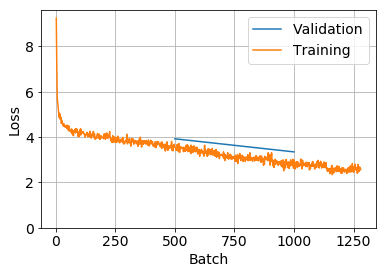

In [44]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(val_xs, val_loss, label='Validation')
plt.plot(train_xs, train_loss, label='Training')
plt.grid()
plt.ylim(bottom=0)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

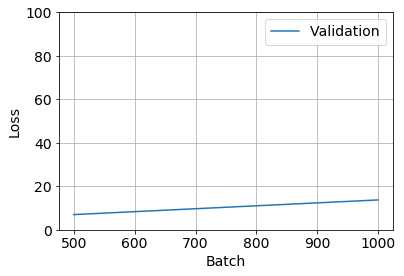

In [48]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(val_xs, val_bleu, label='Validation')
plt.grid()
plt.ylim(bottom=0, top=100)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()